In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
layer_size = 3
out_channels = 64
kernel_size = 5
hidden_size = 2500
mogrify_rounds = 5

In [5]:
import xarray as xr
data_path = '../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([8376, 1, 5, 50, 50])
Y :  torch.Size([8376, 1, 50, 50])
-----Val-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 50, 50])
-----Test-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 50, 50])


In [8]:
params = {'batch_size': batch_size,
          'num_workers': 4}

train_loader = DataLoader(dataset=train_data, shuffle=True,drop_last=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, drop_last=True, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, drop_last=True, **params)

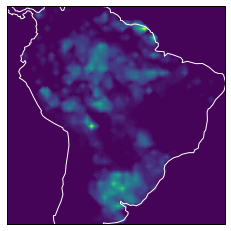

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [10]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        if (weight is not None):
            self.weight = Parameter(weight.permute(1,0,2,3))
        
    def forward(self,input):
        return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [11]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels):
        super(EncoderCNN, self).__init__()
        self.conv_layers = torch.nn.ModuleList()
        self.relu_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.relu_layers.append(torch.nn.ReLU())
            in_channels = out_channels
            
            
            
    def forward(self, x):
        for conv, relu in zip(self.conv_layers, self.relu_layers):
            x = conv(x)
            x = relu(x)
        return x

In [12]:
class DecoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, encoder_weights):
        super(DecoderCNN, self).__init__()
        self.conv_layers = torch.nn.ModuleList()
        self.relu_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size, weight=encoder_weights[i]))
            self.relu_layers.append(torch.nn.ReLU())
            in_channels = out_channels
            
    def forward(self, x):
        for conv, relu in zip(self.conv_layers, self.relu_layers):
            x = conv(x)
            x = relu(x)
        return x

In [13]:
class STModel(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, out_channels, in_channels, input_width, input_height, recurrent_hidden):
        super(STModel, self).__init__()
        self.encoder = EncoderCNN(layer_size = layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels)
        encoder_weights = [layer.weight for layer in self.encoder.conv_layers][::-1]
        self.recurrent = torch.nn.LSTM(input_width*input_height, recurrent_hidden, batch_first=True);
        self.decoder = DecoderCNN(layer_size = layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, encoder_weights = encoder_weights)
        
        
    def forward(self, x):
        batch, channel, time, lat, lon = x.size()
        x_input = x.view(batch*time, channel, lat, lon)
        x = self.encoder(x_input)
        #flatten
        x = x.view(batch, time, -1)
        h_new, c_new = self.recurrent(x)
        x = h_new[:, -1, :]
        #revert to original dimensions
        x = x.contiguous().view(batch, channel, lat, lon)
        x = self.decoder(x)
        return x
        

In [14]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss


In [15]:
class Evaluator:
    def __init__(self, model, loss, data_loader, device):
        self.model = model
        self.loss = loss
        self.data_loader = data_loader
        self.device = device
        
    def evaluate(self):
        with torch.no_grad():
            eval_loss = 0.0
            self.model.eval()
            for i, (x, y) in enumerate(self.data_loader):
                x,y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.loss(output, y)
                eval_loss += loss.detach().item()
            avg_loss = eval_loss/len(self.data_loader)
        return avg_loss

class TrainingStop:
    def __init__(self, threshold):
        self.min_loss = sys.float_info.max
        self.count = 0
        self.threshold = threshold
        
    def check_stop_condition(self, curr_loss):
        if (curr_loss < self.min_loss):
            self.min_loss = curr_loss
            self.count = 0
            return False
        else:
            self.count += 1
            if (self.count >= self.threshold):
                return True
            return False

In [16]:
model = STModel(layer_size = layer_size, kernel_size = kernel_size, out_channels = out_channels, in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], input_height = train_data.x.shape[4], recurrent_hidden = hidden_size).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'alpha': 0.9, 
              'eps': 1e-6}
optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

In [17]:
train_losses, val_losses = [], []
evaluator = Evaluator(model, criterion, val_loader, device)
training_stopper = TrainingStop(3)
for epoch in range(1,100):
    train_loss = model.train()
    epoch_train_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.detach().item()
    print(epoch_train_loss)
    avg_epoch_loss = epoch_train_loss/len(train_loader)
    train_losses.append(avg_epoch_loss)
    print('Train - Epoch %d, Batch: %d, Epoch Loss: %f' % (epoch, i, avg_epoch_loss))
    
    avg_loss = evaluator.evaluate()
    val_losses.append(avg_loss)
    print('Val Avg. Loss: %f' % (avg_loss))
    if (torch.cuda.is_available()):
                torch.cuda.empty_cache()
    if (training_stopper.check_stop_condition(avg_loss)):
        break

2147.2370142936707
Train - Epoch 1, Batch: 334, Epoch Loss: 6.409663
Val Avg. Loss: 6.378919
2127.6672945022583
Train - Epoch 2, Batch: 334, Epoch Loss: 6.351246
Val Avg. Loss: 6.373843
2118.252959251404
Train - Epoch 3, Batch: 334, Epoch Loss: 6.323143
Val Avg. Loss: 6.429795
2119.8268542289734
Train - Epoch 4, Batch: 334, Epoch Loss: 6.327841
Val Avg. Loss: 6.339444
2111.2949018478394
Train - Epoch 5, Batch: 334, Epoch Loss: 6.302373
Val Avg. Loss: 6.356162
2115.876091003418
Train - Epoch 6, Batch: 334, Epoch Loss: 6.316048
Val Avg. Loss: 6.434092
2112.071635246277
Train - Epoch 7, Batch: 334, Epoch Loss: 6.304691
Val Avg. Loss: 6.503286


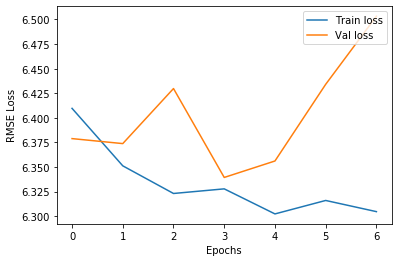

In [18]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [19]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.evaluate()
loss_type = type(criterion).__name__
print(f'STTSModel {loss_type}: {test_loss:.4f}')

STTSModel RMSELoss: 6.4281
